In [1]:
#Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pd.options.display.mpl_style = 'default'

%matplotlib inline

In [2]:
#Load the dataset and store in the variable 'df'
df = pd.read_csv('/Users/colby.schrauth/Desktop/DataScience/query_result.csv')

In [3]:
#Preview the dataframe
#df.head()

In [4]:
#List the columns and store them in the variable 'cols'
cols = list(df)

In [5]:
#Push the 'enabled' column to the front of the dataframe
cols.insert(0, cols.pop(cols.index('enabled')))

#Reorder the dataframe w/ the newly ordered list
df = df.ix[:, cols]

In [6]:
#Repeat
cols.insert(4, cols.pop(cols.index('#_lang')))
df = df.ix[:, cols]

#Repeat
cols.insert(5, cols.pop(cols.index('#_features')))
df = df.ix[:, cols]

#Repeat
cols.insert(6, cols.pop(cols.index('case_count')))
df = df.ix[:, cols]

In [7]:
#Preview the dataframe
#df.head()

In [8]:
#Replace NaN values in 'acct_geo' w/ 'NA'
#df["acct_geo"].replace(np.nan,'NA', inplace=True)

In [9]:
#Preview the get_dummies function on the 'acct_geo' column
#dummy_update = pd.get_dummies(df["acct_geo"])

In [10]:
#Produce dummy variables for 'acct_geo' and append them to the original dataframe
df = pd.concat([df, pd.get_dummies(df['acct_geo'])], axis=1)

In [11]:
#Preview the dataframe
#df.head()

In [12]:
#Delete the original 'acct_geo' column from the dataframe
del df['acct_geo']

In [13]:
#Preview the dataframe
#df.head()

In [14]:
#Print the shape (rows, columns) of 'df'
#print df.shape

In [15]:
#Standardize the dataset
scaler = StandardScaler()
df_norm = scaler.fit_transform(df.iloc[:,3:7])

In [16]:
#Convert df_norm back to a dataframe
df_norm = pd.DataFrame(df_norm)

In [17]:
#Append the scaled columns back to the original dataframe
df = pd.concat((df, df_norm),1)

#Keep 'df_norm' as the dataframe to push through the algorithm
df_norm = df

In [18]:
#Drop the normalized columns in the original dataframe
df = df.drop([0, 1, 2, 3], axis=1)

In [19]:
#Drop the non-normalized columns in the new dataframe
df_norm = df_norm.drop(['comm_age', '#_lang', '#_features', 'case_count'], axis=1)

In [20]:
#Preview the dataframe
#df.head()

In [21]:
#Rename the normalized columns in the new dataframe back to their proper title
df_norm = df_norm.rename(columns = {
    0:'comm_age',
    1:'#_lang',
    2:'#_features',
    3:'case_count',
})

In [22]:
#Preview the dataframe
#df_norm.head()

In [23]:
#Slice the categorical/text based columns from the dataframe to prepare for clustering
df_norm = df_norm.iloc[:,4:]

In [24]:
#Preview the dataframe
#df_norm.head()

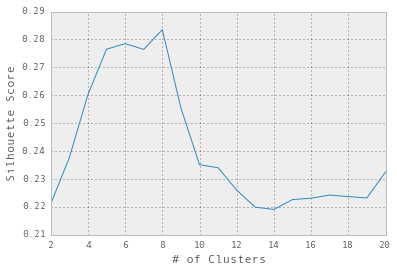

In [25]:
#Setup a range to iterate through for the sake of plotting the Silhouette Score
cluster_range = range(2,21)

#Instantiate an empty list to store the results
score_list = []

#Run a loop through each value for n_clusters
for i in cluster_range:
    #Instantiate KMeans and fit the data to the curated dataframe
    kmeans = KMeans(n_clusters = i, random_state = 1).fit(df_norm)
    #Push KMeans labels to the variable 'labels'
    labels = kmeans.labels_
    #Append each score back to the empty list
    score_list.append(silhouette_score(df_norm,labels,metric='euclidean'))

#Plot each score vs. n_clusters
plt.plot(cluster_range, score_list)
plt.xlabel('# of Clusters')
plt.ylabel('Silhouette Score')

In [26]:
#Find the local maxima to identify the correct # of clusters
cluster_count = 2 + max(enumerate(score_list),key=lambda x: x[1])[0]

#Display the number of clusters to be used in the model moving forward
#cluster_count

In [27]:
#Instantiate KMeans and cluster the dataset around n (n = 'cluster_count') centroids
kmeans = KMeans(n_clusters = cluster_count, random_state = 1).fit(df_norm)

In [28]:
#Store labels in the variable 'labels'
labels = kmeans.labels_

In [29]:
#Store cluster center locations in the variable 'centroids'
centroids = kmeans.cluster_centers_

In [30]:
#Add labels as a column to the dataframe
df['labels'] = labels

In [31]:
#Display the silhouette score for n clusters
silhouette_score(df_norm,labels,metric='euclidean')

0.28352192539812349

In [32]:
#Display the distribution of accounts by centroid, and whether or not they're enabled
#print (pd.crosstab(labels, df["enabled"]))

In [33]:
#Create column names for the KMeans summary dataframe
summary_columns = ['cluster', 'cluster_total', 'cluster_%', 'enabled_#', 'disabled_#', 'enabled_%', 'disabled_%']
#headers = list.pop(0)

In [34]:
#Create an empty list to store summary values
summary_values = []

In [35]:
#Generate values for creating a tabular view of the KMeans summary
for i in range(cluster_count):
    total_in_cluster = float(len(df[df['labels'] == i]))
    enabled_count = len(df[(df['labels']==i) & (df['enabled']==1)])
    disabled_count = total_in_cluster - enabled_count
    d = [i, total_in_cluster, "%.4f" %(total_in_cluster / len(df)), enabled_count, disabled_count,
         "%.4f" %(enabled_count/total_in_cluster),
         "%.4f" %(disabled_count/total_in_cluster)]
    summary_values.append(d)

In [36]:
#Push summary values to their associated column names and create a dataframe
summary_df = pd.DataFrame(summary_values, columns=summary_columns)

In [37]:
#Display the summary table, sorted by disabled in descending order
summary_df.sort_values(['cluster_total'], ascending=False)

,cluster,cluster_total,cluster_%,enabled_#,disabled_#,enabled_%,disabled_%
1,1,254,0.2495,186,68,0.7323,0.2677
5,5,248,0.2436,49,199,0.1976,0.8024
0,0,214,0.2102,167,47,0.7804,0.2196
6,6,179,0.1758,130,49,0.7263,0.2737
2,2,86,0.0845,67,19,0.7791,0.2209
4,4,24,0.0236,16,8,0.6667,0.3333
7,7,10,0.0098,9,1,0.9000,0.1000
3,3,3,0.0029,3,0,1.0000,0.0000


In [38]:
#Instantiate PCA, and force it to create 2 columns
pca_2 = PCA(2)

In [39]:
#Turn the normalized dataframe into two columns with PCA
plot_columns = pca_2.fit_transform(df_norm)

/Users/colby.schrauth/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


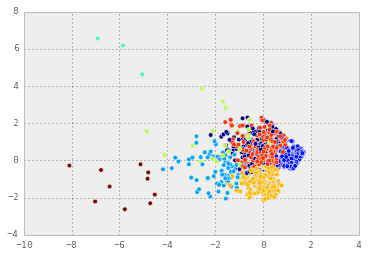

In [40]:
#Plot customers based on the two dimensions, and shade by cluster label
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=kmeans.labels_)
plt.show()

In [ ]:
#Export the updated dataframe to a csv
df.to_csv('test.csv')

In [ ]:
#Raw data for plot
plot_df = pd.DataFrame(plot_columns)
plot_df.to_csv('rawplotdata.csv')

--------------

------------------

---

In [ ]:
#Visualize the KMeans clustering alogrithm
for i in range(cluster_count):
    # select only data observations with cluster label == i
    ds = plot_columns[np.where(kmeans.labels_==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'xk')
    # make the centroid x's bigger
    plt.setp(lines,ms=15.0)
    plt.setp(lines,mew=2.0)

plt.show()

In [ ]:
#Export the updated dataframe to a csv
df.to_csv('test.csv')

In [ ]:
#industries (4)
#don't normalize binary data
#silhoutte score - local maxima (little bump)
#number of columns
#logistic regression to see if they churned

In [ ]:
data = df[list(df.columns[3:5])]

In [ ]:
scaler = StandardScaler()
data_norm = scaler.fit_transform(data)

In [ ]:
km = KMeans(n_clusters=5)
km.fit(data_norm)

In [ ]:
centroids = km.cluster_centers_
centroids

In [ ]:
labels = km.labels_
labels

In [ ]:
# data = data.as_matrix()

In [ ]:
k = 5

for i in range(k):
    # select only data observations with cluster label == i
    ds = data_norm[np.where(labels==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=15.0)
    plt.setp(lines,mew=2.0)
plt.show()

In [ ]:
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(numpyMatrix,n_clusters=k)

In [ ]:
print labels

In [ ]:
np.savetxt('colby_test.txt', labels) 

In [ ]:
kdd_data = pd.read_csv('http://gadatascience.com/datasets/network_attacks/kddcup.data_10_percent', index_col=False)

In [ ]:
kdd_data.head(5)

In [ ]:
kdd_data.protocol_type.value_counts()

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# Turn categorical features into 1-hot encoded features
categorical_features = kdd_data[['protocol_type', 'service', 'flag']]
dv = DictVectorizer()
cat_matrix = dv.fit_transform(categorical_features.T.to_dict().values())

# Collect the other numerical features
from scipy.sparse import hstack
other_features = kdd_data[['src_bytes', 'dst_bytes', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds']]
data_matrix = hstack([cat_matrix, other_features])
data_matrix

In [ ]:
from sklearn.preprocessing import scale
data_matrix = scale(data_matrix.todense())

In [ ]:
from sklearn.cluster import KMeans

clustering_model = KMeans(n_clusters = 25)
clustering_model.fit(data_matrix)

clusters = clustering_model.predict(data_matrix)

clusters

In [ ]:
results = pd.DataFrame({ 'cluster' : clusters, 'class' : kdd_data['class']})
cluster_counts = results.groupby('cluster')['class'].value_counts()
for i in xrange(len(cluster_counts)):
    print("Cluster " ,i)
    print(cluster_counts[i])
    print()

## Change of pace ##

In [ ]:
import pandas as pd

In [ ]:
# READ IN DATASET
votes = pd.read_csv('/Users/colby.schrauth/Desktop/DataScience/114_congress.csv')
votes.head(3)

In [ ]:
# PRINT THE DATASET SHAPE
print votes.shape

In [ ]:
# PRINT THE UNIQUE VALUES AND THEIR ASSOCIATED FREQUENCY
print (pd.value_counts(votes.iloc[:,3:].values.ravel()))

In [ ]:
# IMPORT KMEANS
from sklearn.cluster import KMeans

In [ ]:
# CREATE A KMEANS MODEL W/ 2 CENTROIDS -- RANDOM_STATE HELPS ENSURE THE ALGORITHM RETURNS THE SAME RESULTS EACH TIME
kmeans_model = KMeans(n_clusters = 2, random_state = 1).fit(votes.iloc[:,3:])

In [ ]:
# THESE ARE OUR FITTED LABELS FOR CLUSTERS -- THE FIRST CLUSTER HAS LABEL 0, AND THE SECOND HAS LABEL 1
labels = kmeans_model.labels_

In [ ]:
# SEPARATE EVERYONE INTO PARTIES BASED ON VOTING HISTORY
print (pd.crosstab(labels, votes["party"]))

**APPENDIX**

In [ ]:
#Reshape for clustering with one feature input
df_norm = np.reshape(df_norm, (len(df), 1))